# **Implementation of a Single Layer Neural Netork by Gradient Descent**

### **Setup**

In [1]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgressNetwork, plotProgressOCR, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

---
### **Single layer neural network**

In this notebook, a single layer neural network is implemented, meaning that the predicted classes will be based on linear combinations of the input fetaures.

The training of the network includes three parts that are devided into different functions; the forward pass, the backward pass and the weight update. 

#### **Implementing the forward pass**
The function preforms one forward pass of the single layer network. It takes input samples, calculates the output for each sample using the provided weights and biases, and returns both the raw output and the resulting label for each sample.

In [19]:
def forward(X, W, B, useTanhOutput=False):
    """Forward pass of single layer network.
    Args:
        X (array): Input samples.
        W (array): Neural network weights.
        B (array): Neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
    """
    Z = X @ W + B

    if useTanhOutput:
        Y = np.tanh(Z)
    else:
        Y = Z
        
    # Calculate labels
    L = np.argmax(Y, axis=1)
    
    return Y, L

#### **Implementing the backward pass**

This function computes gradients for the network weights and biases with respect to the loss function based on predicted and target outputs, considering whether the network utilizes a tanh activation function on its output layer, returning these gradients for parameter updates.

In [20]:
def backward(W, B, X, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W (array): Current values of the network weights.
        B (array): Current values of the network biases.
        X (array): Training samples.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool) (optional):
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW (array): Gradients with respect to W
        GradB (array): Gradients with respect to B
    """
    
    N = Y.shape[0]
        
    # Calculate the gradients
    if useTanhOutput:
        GradW = (1/N) * X.T @ ((Y - D) * (1 - (Y**2)))
        GradB = (1/N) * np.sum( (Y - D) * (1 - (Y**2)))
    else:
        GradW = (1/N) * X.T @ (Y - D)
        GradB = (1/N) * np.sum( (Y - D), axis=0)
        
    
    return GradW, GradB

#### **Implementing the weight update**

This function updates and returns the new weights and biases using gradient descent.

In [21]:
def update(W, B, GradW, GradB, params):
    """Update weights and biases using computed gradients.

    Args:
        W (array): Current values of the network weights.
        B (array): Current values of the network biases.
        GradW (array): Gradients with respect to W.
        GradB (array): Gradients with respect to B.
        
        params (dict):
            - learningRate: Scale factor for update step.
        
    Returns:
        W (array): Updated weights.
        B (array): Updated biases.
    """
    
    LR = params["learningRate"]
    
    W = W - LR * GradW
    B = B - LR * GradB
    
    
    return W, B
    

#### **The training function (given)**

The given training function trains the single-layer neural network with given data and parameters, iteratively updating weights and biases, evaluating performance, and returning the trained parameters along with metrics such as losses and accuracies for training and test data. The network is trained for a specified number of epochs while tracking and plotting the training process. 

In [5]:
def trainSingleLayer(XTrain, DTrain, XTest, DTest, W0, B0, params, plotProgress=True):
    """Trains a single-layer network.

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W0 (array): Initial values of the network weights.
        B0 (array): Initial values of the network biases.
        
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.
            useTanhOutput (bool): Determines if output layer should use tanh activation.

    Returns:
        W (array): Weights after training.
        B (array): Biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}
    
    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False

    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]

    # Set initial weights
    W = W0
    B = B0

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred = forward(XTrain, W, B, params["useTanhOutput"])
    YTest , LTestPred  = forward(XTest , W, B, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan #((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan #((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan #(LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan #(LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    if W0.shape[0] < 64:
        fig = plt.figure(figsize=(20,8), tight_layout=True)
    else:
        fig = plt.figure(figsize=(20,8), constrained_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # Compute gradients...
        GradW, GradB = backward(W, B, XTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W, B = update(W, B, GradW, GradB, params)
        
        # Evaluate errors
        YTrain, LTrainPred = forward(XTrain, W, B, params["useTanhOutput"])
        YTest , LTestPred  = forward(XTest , W, B, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % (params["epochs"] // 25)) or n == params["epochs"]:
            if W0.shape[0] < 64:
                plotProgressNetwork(fig, W, B, metrics, n=n, cmap='coolwarm')
            else:
                plotProgressOCR(fig, W, metrics, n=n, cmap='coolwarm_r')

    return W, B, metrics

This following function normalize the input data, this to improve the network's preformance and avoid certain features to dominate the learning process.


In [26]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

---
### **Optimizing each dataset**

This function simplifies the training of a single-layer neural network on a specific dataset. The functions begins with the loading of the data and splitting it into train and test datasets. Optionally, it normalizes the data if specified in the parameters. It then trains the network using the provided initial weights and biases and evaluates its performance on the test set by computing accuracy and confusion matrix. Finally, it displays the results and visualizes the network's output.

In [24]:
def trainSingleLayerOnDataset(datasetNr, testSplit, W0, B0, params):
    """Train a single layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W0 (array): Initial values of the network weights.
        B0 (array): Initial values of the network biases.
        
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.
            normalize (bool): Should data be normalized?
            useTanhOutput (bool): Should tanh activation be used for outputs?
    """

    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    D = np.round(D)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)

    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest
    
    # Train network
    W, B, metrics = trainSingleLayer(XTrainNorm, DTrain, XTestNorm, DTest, W0, B0, params, plotProgress=True)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W, B)[1]
    LPredTest = forward(XTestNorm, W, B)[1]
    
    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest = calcAccuracy(LPredTest, LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    
    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W, B)[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **Optimizing dataset 1**

The first dataset consists of two classes that are somewhat linearly seperable.

Train accuracy: 0.9900
Test accuracy: 0.9933
Test data confusion matrix:
[[150.   0.]
 [  2. 148.]]


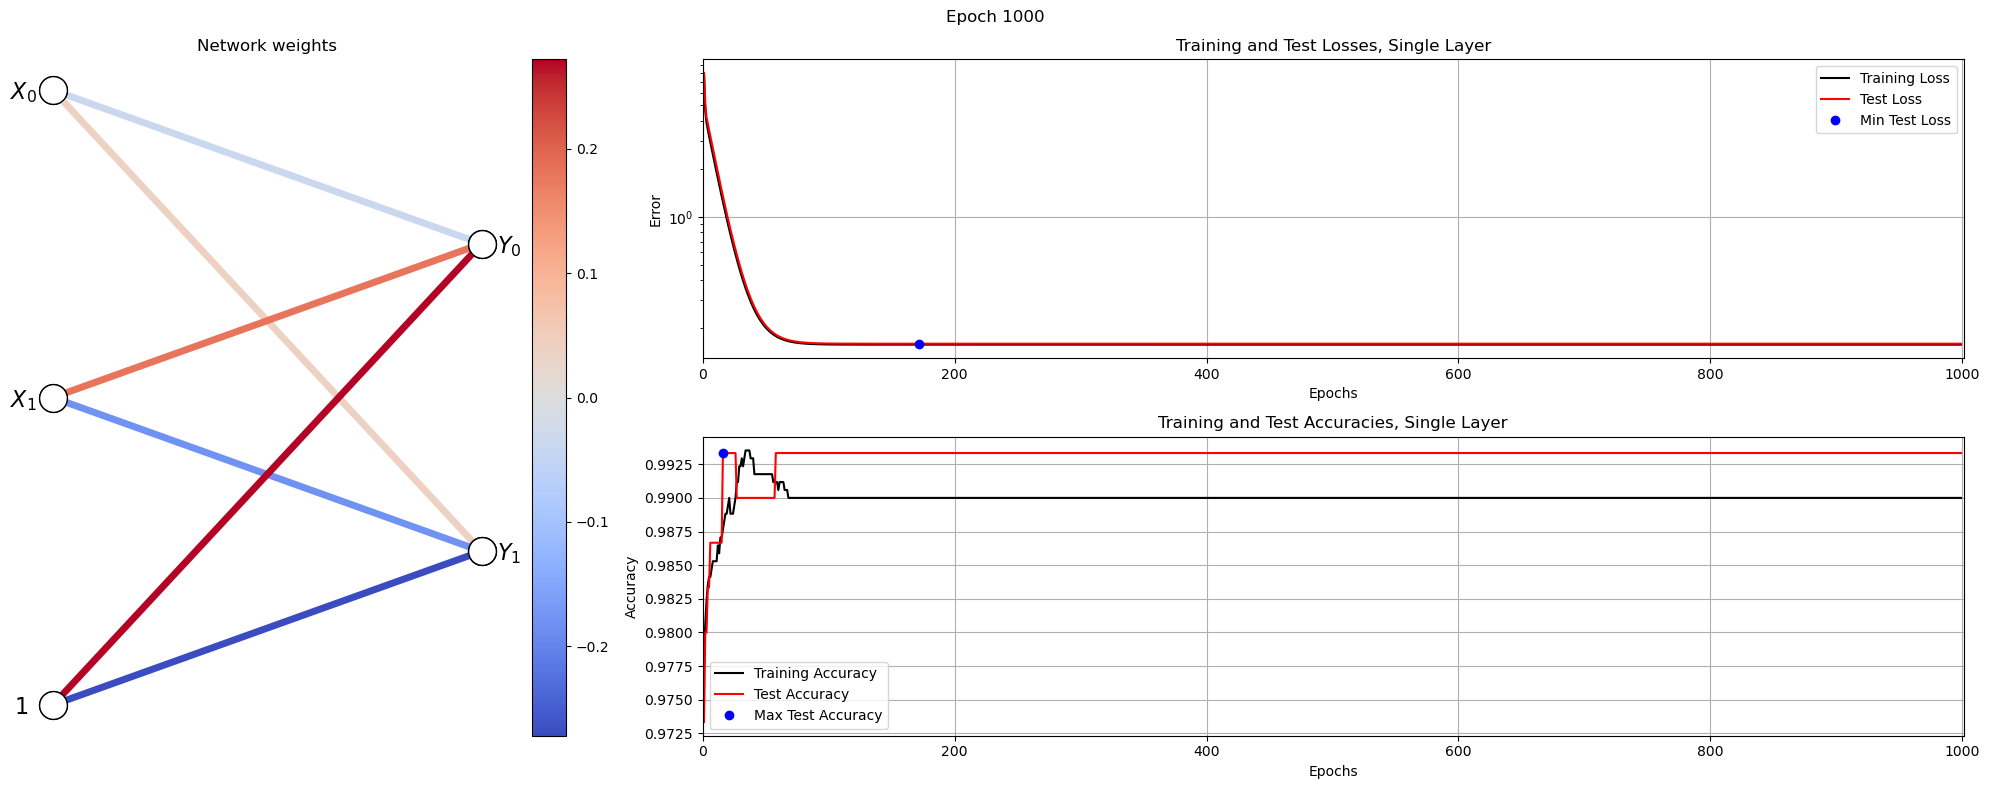

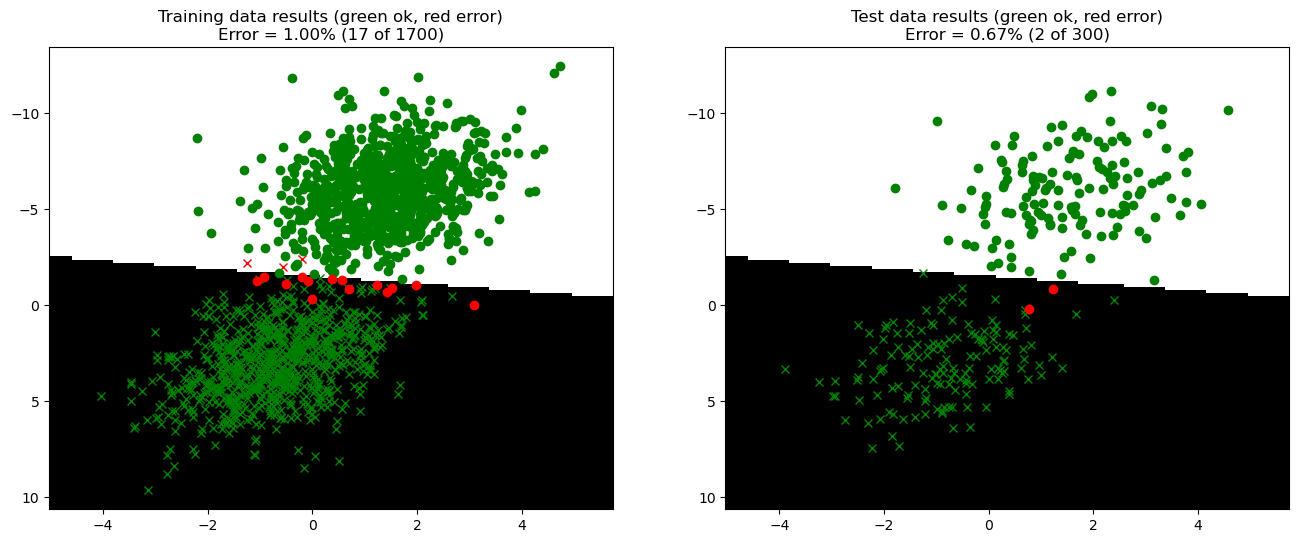

In [27]:
nInputs  = 2
nClasses = 1

W0 = np.random.randn(nInputs, nClasses) 
B0 = np.random.randn(1, nClasses)

params = {"epochs": 1000, "learningRate": 0.05, "normalize": False, "useTanhOutput": False}
# ============================================

trainSingleLayerOnDataset(1, 0.15, W0, B0, params)

#### **Optimizing dataset 2**
The second dataset also consists of two classes, but this time they are not linearly seperable at all, which will result in a low accuracy when using a single layer neural network on this dataset.

Train accuracy: 0.3029
Test accuracy: 0.3100
Test data confusion matrix:
[[  0. 153.]
 [ 54.  93.]]


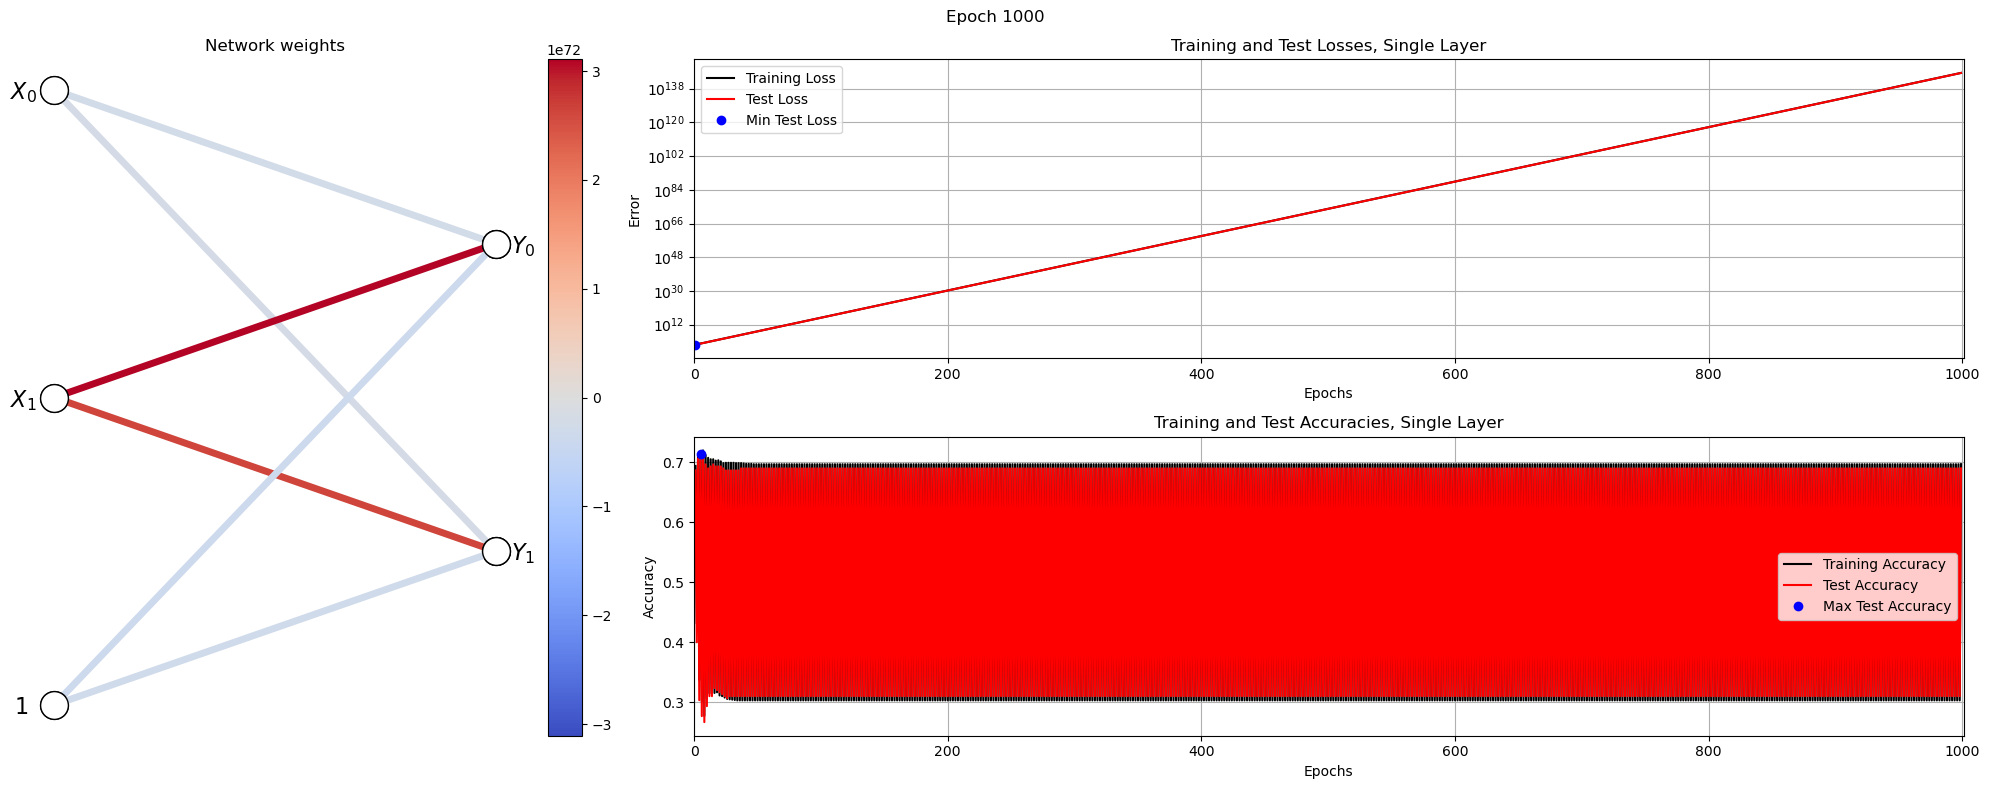

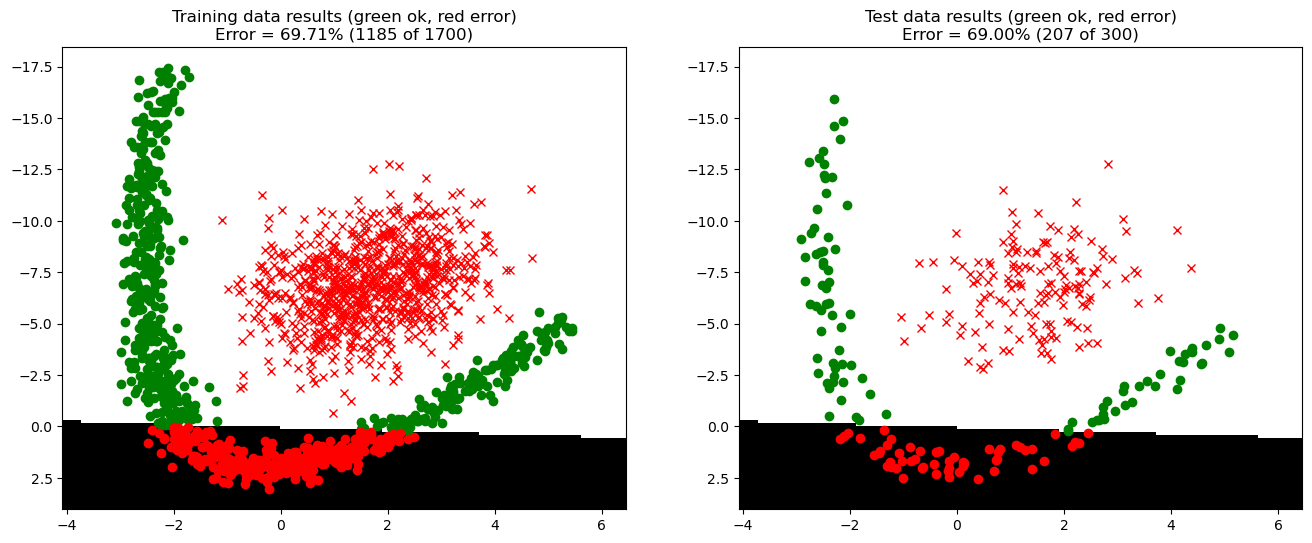

In [31]:
nInputs  = 2
nClasses = 1

W0 = np.random.randn(nInputs, nClasses)
B0 = np.random.randn(1, nClasses)

params = {"epochs": 1000, "learningRate": 0.05, "normalize": False, "useTanhOutput": False}

trainSingleLayerOnDataset(2, 0.15, W0, B0, params)

#### **Optimizing dataset 3**

This dataset consists of three classes.

Train accuracy: 0.8918
Test accuracy: 0.8833
Test data confusion matrix:
[[ 81.   8.  12.]
 [ 14.  83.   1.]
 [  0.   0. 101.]]


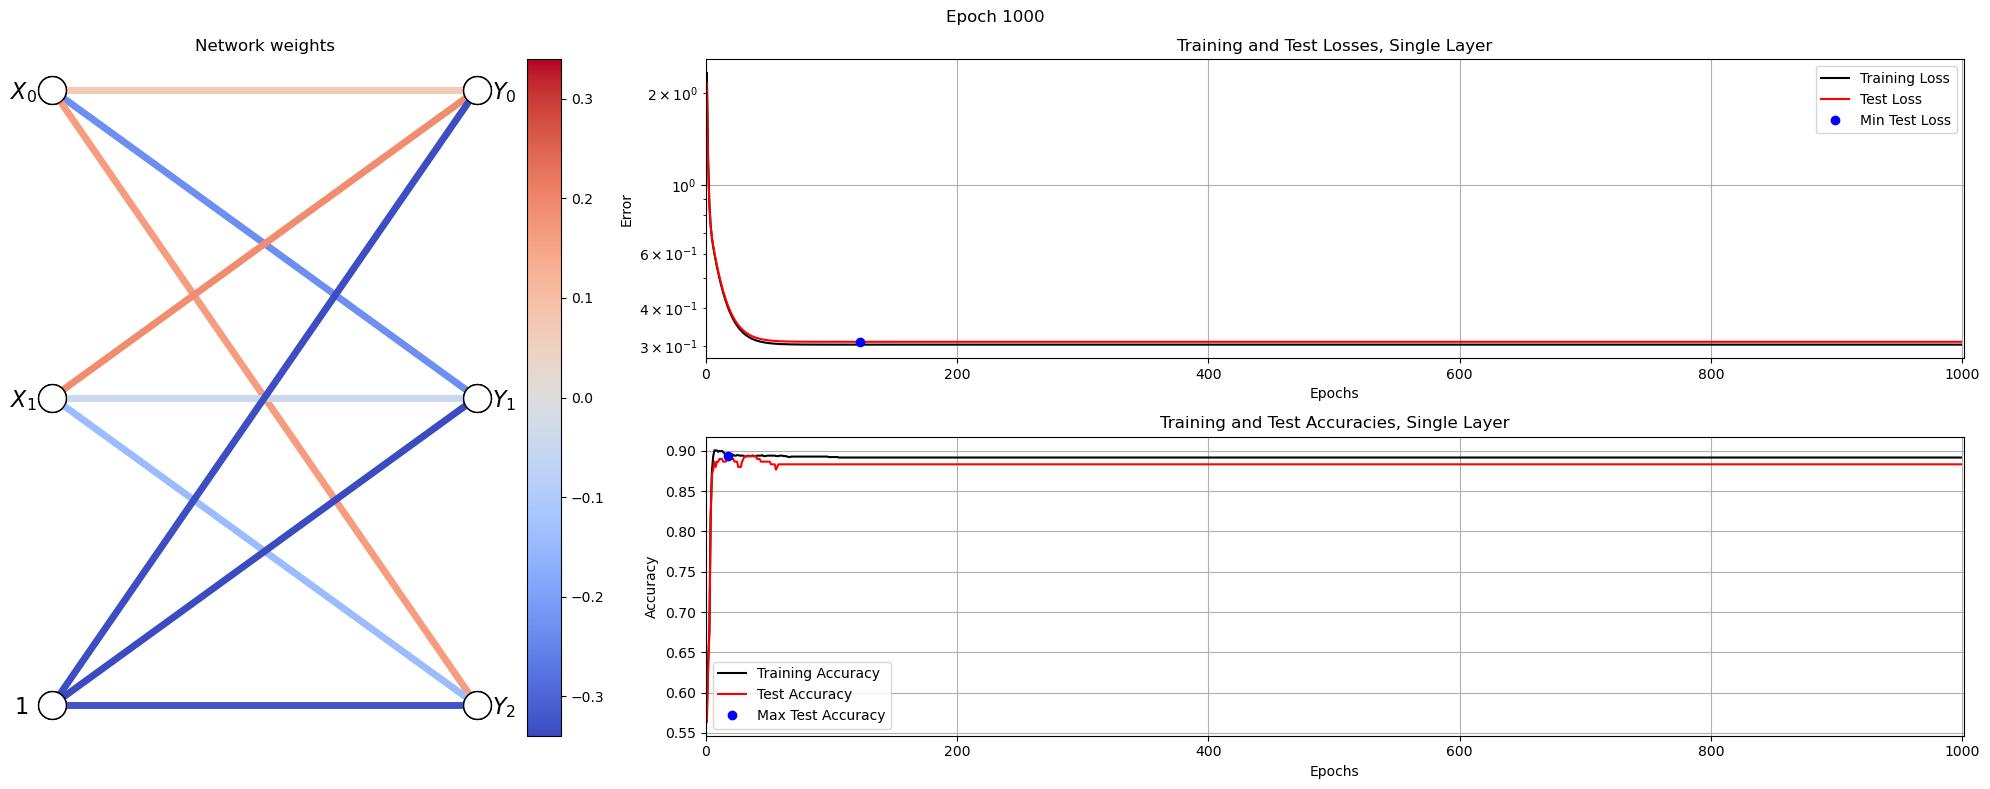

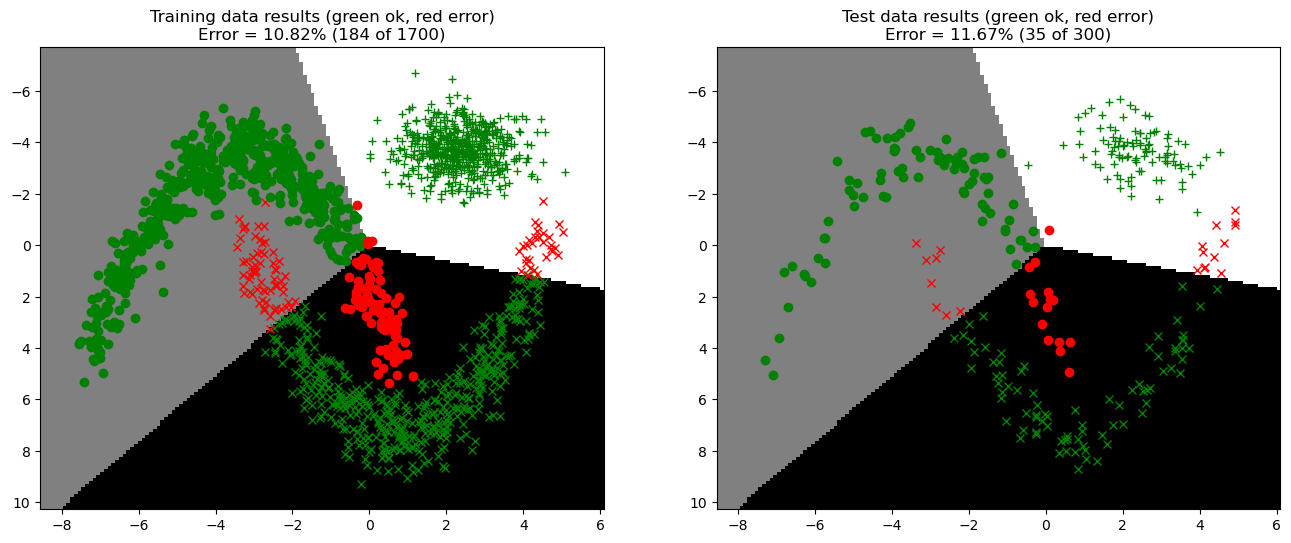

In [29]:
nInputs  = 2
nClasses = 3

W0 = np.random.randn(nInputs, nClasses) 
B0 = np.random.randn(1, nClasses)

params = {"epochs": 1000, "learningRate": 0.05, "normalize": False, "useTanhOutput": False}

trainSingleLayerOnDataset(3, 0.15, W0, B0, params)

#### **Optimizing dataset 4**

This data consists of hand written digits between 0-9, i.e. 10 different output classes. When using a single layer network to classify the samples in this dataset we get suprisingly high accuracy, this is due to the high dimension of the input data and low dimension of the output data the model is able to learn and recognize patterns
in the data.

Train accuracy: 0.9403
Test accuracy: 0.9336
Test data confusion matrix:
[[ 86.   0.   0.   0.   0.   1.   1.   0.   0.   0.]
 [  0.  78.   2.   1.   1.   0.   0.   0.   4.   2.]
 [  1.   0.  79.   2.   0.   0.   0.   0.   2.   1.]
 [  0.   1.   0. 104.   0.   0.   0.   0.   1.   1.]
 [  0.   3.   0.   0.  66.   0.   2.   2.   0.   2.]
 [  1.   0.   1.   1.   0.  77.   0.   0.   0.   3.]
 [  0.   0.   0.   0.   0.   0.  86.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  70.   0.   0.]
 [  1.   3.   0.   0.   0.   2.   0.   1.  65.   1.]
 [  2.   0.   0.   1.   1.   0.   0.   6.   2.  76.]]


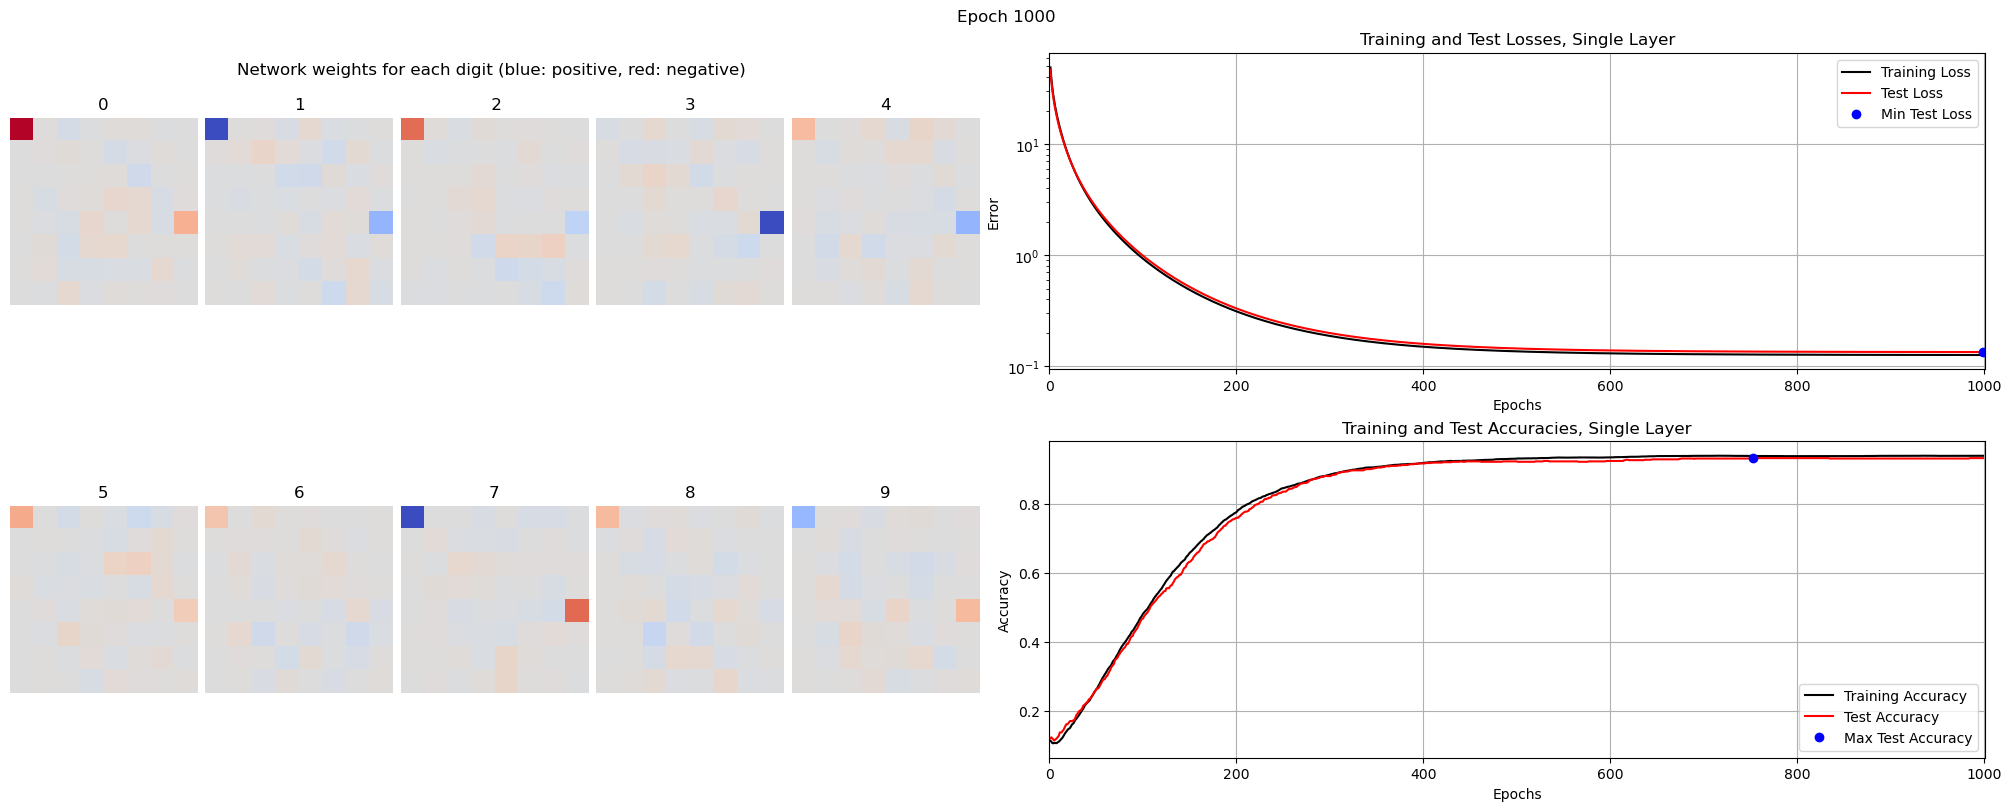

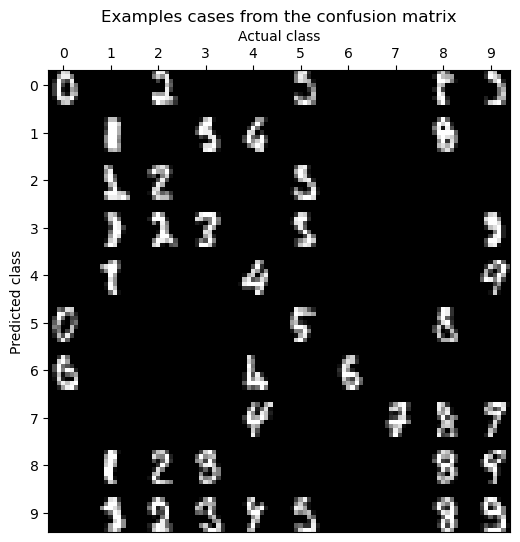

In [30]:
nInputs  = 64
nClasses = 10

W0 = np.random.randn(nInputs, nClasses)
B0 = np.random.randn(1, nClasses)

params = {"epochs": 1000, "learningRate": 0.05, "normalize": True, "useTanhOutput": False}

trainSingleLayerOnDataset(4, 0.15, W0, B0, params)